In [3]:
import pandas as pd
import pubchempy as pcp 
from typing import List
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

from rdkit.Avalon import pyAvalonTools
from tqdm import tqdm
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import joblib
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [4]:
from pathlib import Path

relative_path = Path("..")


In [5]:
train_data = pd.read_csv(relative_path / 'data/raw/train_pom_embeds1.csv')
train_data = train_data.drop_duplicates(subset=['ConnectivitySMILES'], keep='first')

In [6]:
train_data_feats = pd.read_csv(relative_path / 'data/processed/pubchem_info.csv')
train_data_feats = train_data_feats[train_data_feats['ConnectivitySMILES'].notna()]
train_data_feats = train_data_feats.drop_duplicates(subset=['ConnectivitySMILES'], keep='first')
train_data_feats = train_data_feats.drop(columns=['Pubchem_ID', 'taste_cluster'])

In [7]:
train = pd.merge(train_data, train_data_feats, on='ConnectivitySMILES', how='inner')

In [8]:
train = train.drop(columns = ['Volume3D', 'EffectiveRotorCount3D'])

In [9]:
test_data = pd.read_csv(relative_path / 'data/raw/test_pom_embeds1.csv')

In [10]:
test_data_feats = pd.read_csv(relative_path / 'data/processed/test_pubchem_props.csv')

In [11]:
test = pd.concat([test_data, test_data_feats], axis=1, join = 'inner')

In [12]:
test = test.drop(columns = ['Volume3D', 'EffectiveRotorCount3D'])

## Доп функции


In [13]:
def drop_correlation_cols(df, threshold):
    df_corr = df.corr().abs()
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    to_drop = [
        column
        for column in df_corr.columns
        if any(df_corr[column] > threshold)
    ]
    df = df.drop(columns=to_drop)
    
    print(f"Количество колонок до удаления: {df_corr.shape[1]}")
    print(f"Количество колонок после удаления: {df.shape[1]}")
    return df

In [14]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## Дескрипторы

In [15]:
def rdkit_descriptors(smiles: List[str], descs: List[str] = None) -> pd.DataFrame:

    mols = [Chem.MolFromSmiles(i) for i in smiles]
    if descs is not None:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)
    else:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(
            [x[0] for x in Descriptors._descList]
        )
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors = []
    for mol in tqdm(mols):
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)

    df = pd.DataFrame(Mol_descriptors, columns=desc_names)
    print("Initial shape:", df.shape)
    nunique = df.nunique(dropna=True)
    df = df.loc[:, nunique > 1]
    df = df.dropna(axis=1)
    print("Shape after dropping NaNs:", df.shape)

    return df

In [16]:
from mordred import Calculator, descriptors


def mordred_descriptors(smiles: List[str]) -> pd.DataFrame:
    calc = Calculator(descriptors, ignore_3D=True)

    results = []
    valid_idx = []
    for idx, smi in enumerate(tqdm(smiles, desc="Calculating Mordred descriptors")):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue
            mol = Chem.AddHs(mol)
            res = calc(mol)
            results.append(res)
            valid_idx.append(idx)
        except Exception as e:
            print(f"Ошибка с молекулой {idx} ({smi}): {e}")
            continue

    if not results:
        raise ValueError("Нет валидных молекул для расчета дескрипторов!")

    desc_df = pd.DataFrame([list(r) for r in results], columns=[str(d) for d in calc.descriptors], index=valid_idx)

    print("Shape of Mordred descriptor matrix before cleaning:", desc_df.shape)

    desc_df = desc_df.apply(pd.to_numeric, errors="coerce")
    desc_df = desc_df.loc[:, desc_df.isna().mean() <= 0.6]
    desc_df = desc_df.fillna(0)
    nunique = desc_df.nunique(dropna=True)
    desc_df = desc_df.loc[:, nunique > 1]
    desc_df = desc_df.dropna(axis=1)
    print("Shape of Mordred descriptor matrix after cleaning:", desc_df.shape)

    return desc_df


## Вытащим с пабкема всё

In [ ]:
def fetch_pubchem_props(cid: int):
    try:
        props = pcp.get_properties([
            "ConnectivitySMILES",  
            "MolecularFormula",
            "MolecularWeight",
            "XLogP",
            "TPSA",
            "HBondDonorCount",
            "HBondAcceptorCount",
            "RotatableBondCount",
            "HeavyAtomCount",
            "AtomStereoCount",
            "BondStereoCount",
            "Complexity",
            "Charge",
            "Volume3D",
            "EffectiveRotorCount3D"],
            int(cid)
        )
        return props[0]
    except Exception as e:
        print("error", cid, e)
        return None


In [ ]:
dicts = []
for i in tqdm(range(len(test_data))):
    cid = test_data.loc[i, 'Pubchem_ID']
    prop = fetch_pubchem_props(cid)
    if prop is not None:
        dicts.append(prop)
    else:
        dicts.append({})

In [ ]:
for i in dicts :
    for key in i.keys():
        test_data.loc[dicts.index(i), key] = i[key]

In [ ]:
test_data.to_csv(relative_path / 'data/processed/test_pubchem_props.csv', index=False)

## Генерация фингерпринтов

In [ ]:
def morgan_fpts(
    smiles: List[str], rad: int = 2, bits: int = 1024
) -> pd.DataFrame:

    morgan_fpts = []
    mgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    for smi in tqdm(smiles):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            morgan_fpts.append(np.zeros(bits, dtype=int))
            continue

        fp = mgen.GetFingerprint(mol)    
        arr = np.zeros(bits, dtype=int) 
        DataStructs.ConvertToNumpyArray(fp, arr)
        morgan_fpts.append(arr)

    df = pd.DataFrame(
        morgan_fpts, columns=[f"MorgFPT_{i}" for i in range(bits)]
    )
    return df

In [ ]:
def generate_AVfpts(mols: List[Chem.rdchem.Mol], bits: int = 4096) -> pd.DataFrame:
    avalon_fpts = []
    for mol in tqdm(mols):
        fpt = pyAvalonTools.GetAvalonFP(mol, nBits=bits)
        avalon_fpts.append(np.array(fpt))

    df = pd.DataFrame(
        avalon_fpts, columns=[f"Col_A_{i+1}" for i in range(bits)]
    )

    return df

## Работаем

In [17]:
train = train.dropna().reset_index(drop=True)

In [18]:
train['taste_cluster'].value_counts()

taste_cluster
0    511
3    398
1    287
4    273
2    210
7    200
6     80
5     41
Name: count, dtype: int64

In [23]:
rdkit_desc_df = rdkit_descriptors(
    train['ConnectivitySMILES'].to_list()
)

100%|██████████| 2000/2000 [00:12<00:00, 155.56it/s]

Initial shape: (2000, 217)
Shape after dropping NaNs: (2000, 170)


In [24]:
rdkit_desc_df = drop_correlation_cols(rdkit_desc_df, 0.9)

Количество колонок до удаления: 170
Количество колонок после удаления: 115


In [25]:
mordred_df = mordred_descriptors(
    train['ConnectivitySMILES'].to_list()
)

Calculating Mordred descriptors: 100%|██████████| 2000/2000 [01:40<00:00, 19.97it/s]


Shape of Mordred descriptor matrix before cleaning: (2000, 1613)
Shape of Mordred descriptor matrix after cleaning: (2000, 1274)


In [ ]:
numeric_train_data = train.select_dtypes(include=['number'])
numeric_train_data

In [38]:
numeric_train_data = train[['taste_cluster', 'MolecularWeight','XLogP','TPSA','Complexity', 'Charge','HBondDonorCount','HBondAcceptorCount','RotatableBondCount','HeavyAtomCount','AtomStereoCount','BondStereoCount']]

In [45]:
descs = pd.concat([numeric_train_data, rdkit_desc_df, mordred_df], axis=1)
descs = drop_correlation_cols(descs, 0.9)
descs.shape

Количество колонок до удаления: 1401
Количество колонок после удаления: 431


(2000, 431)

In [46]:
top_features = descs.corr().abs()['taste_cluster'].\
        drop(columns = 'taste_cluster').\
            sort_values(ascending=False).head(15).drop(columns = ['taste_cluster']).index.tolist()

In [ ]:
numeric_train_data = pd.concat([numeric_train_data, descs[top_features]], axis=1)

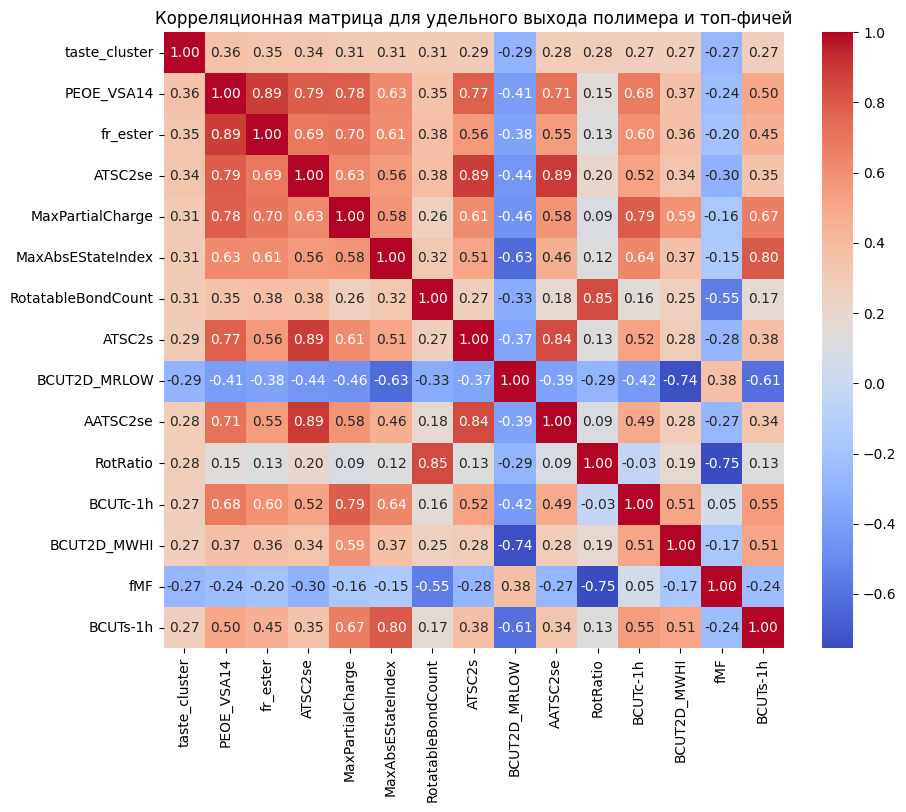

In [47]:
selected_features = top_features
corr_matrix = descs[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица для удельного выхода полимера и топ-фичей')
plt.show()

In [ ]:
numeric_train_data = numeric_train_data.loc[:,~numeric_train_data.columns.duplicated()].copy()

In [ ]:
X = numeric_train_data.drop(columns=['taste_cluster'])
y = train['taste_cluster']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.05, random_state=42, stratify=y, shuffle=True
)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Тестовые


In [ ]:
def rdkit_descriptors(smiles: List[str], descs: List[str] = None) -> pd.DataFrame:

    mols = [Chem.MolFromSmiles(i) for i in smiles]
    if descs is not None:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)
    else:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(
            [x[0] for x in Descriptors._descList]
        )
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors = []
    for mol in tqdm(mols):
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)

    df = pd.DataFrame(Mol_descriptors, columns=desc_names)
    # print("Initial shape:", df.shape)
    # nunique = df.nunique(dropna=True)
    # df = df.loc[:, nunique > 1]
    # df = df.dropna(axis=1)
    print("Shape after dropping NaNs:", df.shape)

    return df

In [ ]:
from mordred import Calculator, descriptors
def mordred_descriptors(smiles: List[str]) -> pd.DataFrame:
    calc = Calculator(descriptors, ignore_3D=True)

    results = []
    valid_idx = []
    for idx, smi in enumerate(tqdm(smiles, desc="Calculating Mordred descriptors")):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue
            mol = Chem.AddHs(mol)
            res = calc(mol)
            results.append(res)
            valid_idx.append(idx)
        except Exception as e:
            print(f"Ошибка с молекулой {idx} ({smi}): {e}")
            continue

    if not results:
        raise ValueError("Нет валидных молекул для расчета дескрипторов!")

    desc_df = pd.DataFrame([list(r) for r in results], columns=[str(d) for d in calc.descriptors], index=valid_idx)

    print("Shape of Mordred descriptor matrix before cleaning:", desc_df.shape)

    desc_df = desc_df.apply(pd.to_numeric, errors="coerce")
    # desc_df = desc_df.loc[:, desc_df.isna().mean() <= 0.6]
    # desc_df = desc_df.fillna(0)
    # nunique = desc_df.nunique(dropna=True)
    # desc_df = desc_df.loc[:, nunique > 1]
    # desc_df = desc_df.dropna(axis=1)
    print("Shape of Mordred descriptor matrix after cleaning:", desc_df.shape)

    return desc_df

In [ ]:
df_rdkit_test = rdkit_descriptors(
    test_data['ConnectivitySMILES'].to_list(), rdkit_desc_df.columns.to_list()
)

In [ ]:
mordred_test_df = mordred_descriptors(
    test['ConnectivitySMILES'].to_list()
)

In [ ]:
descs_test = pd.concat([test, df_rdkit_test], axis=1)
descs_test = descs_test[X.columns.to_list()]

In [ ]:
numeric_test_data = test.select_dtypes(include=['number'])

In [ ]:
X_test = numeric_test_data.loc[:,~numeric_test_data.columns.duplicated()].copy()

In [ ]:
X_test = X_test[X.columns.to_list()]

In [ ]:
X_test = scaler.transform(X_test)

## Какие-то модели

### деревья

In [ ]:
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f1_score(y_val, y_pred, average='macro'))

### бустинг

In [ ]:
cat_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    loss_function="MultiClass",
    eval_metric="TotalF1"
)
cat_clf.fit(X_train, y_train, verbose=100)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = cat_clf.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f1_score(y_val, y_pred, average='macro'))

In [ ]:
pd.DataFrame(y_pred, columns=['taste_cluster']).to_csv(relative_path / 'solution.csv', index=False)

### MLP

In [ ]:
class TasteClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TasteClassifier, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
model = TasteClassifier(input_dim=X_train.shape[1], output_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
class_counts = y_train.value_counts().sort_index().values
weights = 1 / class_counts
weights = weights / weights.mean()
loss = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32))

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype =torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
torch.manual_seed(42)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(450):
    logits = model(X_train_tensor)
    y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    train_loss = loss(logits, y_train_tensor)
    train_acc = accuracy_fn(y_train_tensor, y_pred)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        val_logits = model(X_val_tensor)
        val_y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
        val_loss = loss(val_logits, y_val_tensor)
        val_acc = accuracy_fn(y_val_tensor, val_y_pred)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    if epoch % 25 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


In [ ]:
model.load_state_dict(torch.load(relative_path / 'models/best_model.pth'))

In [ ]:
with torch.inference_mode():
    model.eval()
    val_logits = model(X_val_tensor)
    val_y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
    print(confusion_matrix(y_val_tensor, val_y_pred))
    print(classification_report(y_val_tensor, val_y_pred))
    print(f1_score(y_val_tensor, val_y_pred, average='macro'))

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label="train_acc")
plt.plot(val_accuracies, label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [ ]:
preds = pd.DataFrame(val_y_pred.numpy(), columns=['taste_cluster'])

In [ ]:
preds.to_csv(relative_path / 'solution.csv', index=False)

## GNN


In [ ]:
from rdkit import Chem
import torch
from torch_geometric.data import Data, Dataset
import torch.nn.functional as F

ATOM_LIST = [1, 6, 7, 8, 9, 16, 17, 35, 53]

def atom_features(atom):
    Z = atom.GetAtomicNum()
    z_one_hot = [int(Z == z) for z in ATOM_LIST]
    degree = atom.GetTotalDegree()
    formal_charge = atom.GetFormalCharge()
    aromatic = int(atom.GetIsAromatic())
    return torch.tensor(z_one_hot + [degree, formal_charge, aromatic], dtype=torch.float32)

def bond_features(bond):
    bt = bond.GetBondType()
    return torch.tensor([
        int(bt == Chem.rdchem.BondType.SINGLE),
        int(bt == Chem.rdchem.BondType.DOUBLE),
        int(bt == Chem.rdchem.BondType.TRIPLE),
        int(bt == Chem.rdchem.BondType.AROMATIC),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
    ], dtype=torch.float32)

def smiles_to_graph(smiles: str, y: int, extra_feats: torch.Tensor | None = None) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Bad SMILES: {smiles}")

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0) 

    edge_index_list = []
    edge_attr_list = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)

        edge_index_list += [[i, j], [j, i]]
        edge_attr_list += [bf, bf]

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr_list, dim=0)

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor([y], dtype=torch.long),
    )
    if extra_feats is not None:
        data.extra = extra_feats

    return data


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool

class GINWithExtra(nn.Module):
    def __init__(self, node_in_dim, extra_dim, hidden_dim, num_classes,
                 p_gnn=0.3, p_cls=0.5):
        super().__init__()

        nn1 = nn.Sequential(
            nn.Linear(node_in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv1 = GINConv(nn1)

        nn2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.conv2 = GINConv(nn2)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.p_gnn = p_gnn
        self.p_cls = p_cls

        fusion_dim = hidden_dim + extra_dim

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(self.p_cls),
            nn.Linear(256, num_classes),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(F.relu(x))
        x = F.dropout(x, p=self.p_gnn, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(F.relu(x))
        x = F.dropout(x, p=self.p_gnn, training=self.training)

        g = global_mean_pool(x, batch)

        if hasattr(data, "extra"):
            g = torch.cat([g, data.extra], dim=1)

        g = F.dropout(g, p=self.p_cls, training=self.training)

        logits = self.classifier(g)
        return logits



In [ ]:
smiles = train_data["ConnectivitySMILES"].values
labels = train_data["taste_cluster"].values

import copy
rng = 42
idx = np.arange(len(smiles))
train_idx, val_idx = train_test_split(
    idx, test_size=0.1, random_state=rng, stratify=labels
)

X_arr = X.values.astype("float32")
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(X_arr[train_idx])
X_val_tab   = scaler.transform(X_arr[val_idx])

In [ ]:
graphs_train, graphs_val = [], []
for k, idx_ in enumerate(train_idx):
    extra = torch.tensor(X_train_tab[k], dtype=torch.float32).unsqueeze(0)
    g = smiles_to_graph(smiles[idx_], int(labels[idx_]), extra_feats=extra)
    graphs_train.append(g)

for k, idx_ in enumerate(val_idx):
    extra = torch.tensor(X_val_tab[k], dtype=torch.float32).unsqueeze(0)
    g = smiles_to_graph(smiles[idx_], int(labels[idx_]), extra_feats=extra)
    graphs_val.append(g)

train_dataset = graphs_train
val_dataset = graphs_val


In [ ]:
from torch_geometric.loader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

sample = train_dataset[0]
node_in_dim = sample.x.size(1)
extra_dim   = sample.extra.size(1)
num_classes = len(np.unique(labels))


In [ ]:
def run_epoch(loader, model, optimizer, loss_fn, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = loss_fn(logits, batch.y.view(-1))

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = logits.argmax(dim=1)
            total_loss += loss.item() * batch.num_graphs
            total_correct += (preds == batch.y.view(-1)).sum().item()
            total_n += batch.num_graphs

    return total_loss / total_n, total_correct / total_n, preds

In [ ]:
torch.manual_seed(5)

model = GINWithExtra(node_in_dim, extra_dim, hidden_dim=64, num_classes=num_classes).to(device)
class_counts = np.bincount(labels[train_idx])
w = 1.0 / class_counts
w = w / w.mean()
weights = torch.tensor(w, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_epoch(loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = criterion(logits, batch.y.view(-1))

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = logits.argmax(dim=1)
            total_loss += loss.item() * batch.num_graphs
            total_correct += (preds == batch.y.view(-1)).sum().item()
            total_n += batch.num_graphs

    return total_loss / total_n, total_correct / total_n, preds

epochs = 750
best_val_acc = 0.0
best_state = None
patience, bad = 150, 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    if val_acc > best_val_acc + 1e-3:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        bad = 0
        print(f"New best at epoch {epoch}: val_acc={val_acc:.4f}")
    else:
        bad += 1

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | "
              f"train loss {train_loss:.3f}, acc {train_acc:.3f} | "
              f"val loss {val_loss:.3f}, acc {val_acc:.3f}")

    if bad >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print("Best val acc from loop:", best_val_acc)

model.load_state_dict(best_state)
val_loss2, val_acc2 = run_epoch(val_loader, train=False)
print("Val acc after reload:", val_acc2)


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="train_acc")
plt.plot(val_accs, label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [ ]:
all_preds = []
all_probs = []
all_true  = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        logits = model(batch) 

        probs = torch.softmax(logits, dim=1)      
        preds = probs.argmax(dim=1)               

        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_true.append(batch.y.view(-1).cpu())

all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()
all_true  = torch.cat(all_true).numpy()

print("Shape preds:", all_preds.shape)
print("Val accuracy:", accuracy_fn(torch.tensor(all_true), torch.tensor(all_preds)))


In [ ]:
print(f'Confusion Matrix:\n{confusion_matrix(all_true, all_preds)}')
print(classification_report(all_true, all_preds))